# Read Data

In [1]:
import pandas as pd
# Read the CSVs
footbridge = pd.read_csv('Creek Data/footbridge.csv')

grinnel=pd.read_csv('Creek Data/grinnel.csv')

lbnl_2021_2023=pd.read_csv('lbnl data/LBNL1 Weather Data 2021-2023.csv')

 'BaroPres','DeltaTemp_Avg', 'Dew_Pt_Avg','PanelTmpF_Avg', 'Precip_Tot 'RelHum_Avg''SolRad_Avg'    'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',  'VertWind_Avg', 'VertWind_Max', 'WindGust_Max', 'WndDir', 'WndDir_res',
       'WndSpd', 'WndSpd_dup', 'WndSpd_res''Temp2m_Avg'

# add rain data from open lbnl

In [2]:
import pandas as pd
import numpy as np
# The 'requests' library is no longer needed

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    """
    Cleans, standardizes, and consolidates messy sensor column names in a DataFrame.
    (This function remains unchanged)
    """
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    df.rename(columns=rename_map, inplace=True)
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        if df.columns.tolist().count(name) > 1:
            dup_cols_df = df.loc[:, df.columns == name]
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            df.drop(columns=[name], inplace=True)
            df[name] = consolidated_series

## NEW HELPER FUNCTION ##
def prepare_lbnl_weather_data(lbnl_df):
    """
    Selects required columns from the LBNL weather data, renames the timestamp,
    and prepares it for merging.
    """
    # Define the columns you want to keep from the LBNL dataset
    columns_to_keep = [
        'Timestamp (UTC-8)', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg',
        'Precip_Tot', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',
        'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max',
        'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Avg'
    ]

    # Filter for the columns we need
    weather_df = lbnl_df[columns_to_keep].copy()

    # Rename columns for consistency and merging
    weather_df.rename(columns={
        'Timestamp (UTC-8)': 'datetime',
        'Precip_Tot': 'rain_mm'  # Renaming for compatibility with plotting functions
    }, inplace=True)

    # Ensure the datetime column is the correct data type
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

    # Sort by datetime, which is required for merge_asof
    weather_df.sort_values('datetime', inplace=True)

    return weather_df

# ===================================================================
#  2. MAIN PROCESSING FUNCTION (MODIFIED)
# ===================================================================

## MODIFIED MAIN FUNCTION ##
def create_final_dataset(file_path_map, lbnl_weather_df):
    """
    Loads, cleans, and combines sensor data, then merges it with the
    provided LBNL weather DataFrame.
    """
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        df = pd.read_csv(path)
        clean_column_names(df)
        df['location'] = name
        all_sensors_list.append(df)

    # --- Combine and consolidate the cleaned sensor data ---
    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)

    # --- Prepare the local LBNL weather data ---
    print("Preparing LBNL weather data... ☀️")
    weather_df = prepare_lbnl_weather_data(lbnl_weather_df)

    # --- Merge sensor data with the nearest LBNL weather measurement ---
    print("Merging weather data... 🔗")
    all_data = all_data.sort_values('datetime')
    # Use merge_asof to find the closest weather station reading for each sensor reading
    final_df = pd.merge_asof(all_data, weather_df, on='datetime', direction='nearest')

    print("Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

# --- Step 1: Define the paths to your creek data files ---
# !!! This dictionary should still point to your creek sensor files !!!
file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

# --- Step 2: Run the main function with the LBNL DataFrame ---
# !!! Ensure your 'lbnl_2021_2023' DataFrame is loaded before this step !!!
# For example:
# lbnl_2021_2023 = pd.read_csv('path/to/your/lbnl_data.csv')

final_df_MMW_lbnl = create_final_dataset(file_paths, lbnl_2021_2023)

# --- Step 3: Display the result ---



final_df_MMW_lbnl

Loading and cleaning sensor data files...
Preparing LBNL weather data... ☀️
Merging weather data... 🔗
Process complete!


,datetime,conductivity,signal_percent,depth,battery,temperature,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,...,Temp2m_Avg,VertWind_Avg,VertWind_Max,WindGust_Max,WndDir,WndDir_res,WndSpd,WndSpd_dup,WndSpd_res,SolRad_Avg
0,2021-04-30 14:50:00,0.0,90.0,-3.5,4.291,27.75,footbridge,987.4875,-5.088,47.72,...,61.86,0.0,0.0,8.17,230.80,231.80,4.280,4.280,3.785,714.40
1,2021-04-30 14:55:00,0.0,51.0,-3.3,4.230,27.75,footbridge,987.4875,-5.388,47.79,...,63.08,0.0,0.0,8.02,206.20,209.50,3.151,3.151,2.411,679.70
2,2021-04-30 15:00:00,0.0,90.0,-3.7,4.230,27.50,footbridge,987.4875,-5.388,47.79,...,63.08,0.0,0.0,8.02,206.20,209.50,3.151,3.151,2.411,679.70
3,2021-04-30 17:35:00,26.5,NaN,0.0,23.900,10.50,grinnel,986.4113,-2.518,47.16,...,54.88,0.0,0.0,11.07,228.50,228.40,5.911,5.911,5.614,159.00
4,2021-04-30 18:00:00,26.5,NaN,0.0,23.900,10.20,grinnel,986.4538,-1.601,47.21,...,52.79,0.0,0.0,10.99,227.10,226.90,5.511,5.511,5.228,74.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,356.0,84.0,435.3,4.397,45.50,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00
387024,2025-08-09 15:15:00,346.5,84.0,436.8,4.397,45.00,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00
387025,2025-08-09 15:30:00,334.0,81.0,433.0,4.260,44.50,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00
387026,2025-08-09 15:45:00,326.8,84.0,437.5,4.260,44.00,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00


# add rain data from open metreo 

In [3]:
import pandas as pd
import numpy as np
import requests
import re

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    """
    Cleans, standardizes, and consolidates messy sensor column names in a DataFrame.
    This version correctly handles and merges duplicate columns (e.g., two temp sensors).
    """
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }

    # First, create a map of old names to new, simple names
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    
    # Rename the columns. This step may create duplicate column names.
    df.rename(columns=rename_map, inplace=True)

    # Now, find and consolidate the duplicates
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        # Check if any column name was created more than once
        if df.columns.tolist().count(name) > 1:
            # Select all columns with the same duplicate name
            dup_cols_df = df.loc[:, df.columns == name]
            
            # Consolidate them into a single series
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            
            # Drop all columns with the duplicate name from the original dataframe
            df.drop(columns=[name], inplace=True)
            
            # Add the single, consolidated series back
            df[name] = consolidated_series

def get_openmeteo_rain(lat, lon, start, end):
    """Fetches hourly precipitation for a given location and date range."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat, "longitude": lon, "start_date": start, "end_date": end,
        "hourly": "precipitation", "timezone": "auto"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame({
        "datetime": pd.to_datetime(data["hourly"]["time"]),
        "rain_mm": data["hourly"]["precipitation"]
    })
    return df

# ===================================================================
#  2. MAIN PROCESSING FUNCTION
# ===================================================================

def create_final_dataset(file_path_map, lat=37.87, lon=-122.27):
    """
    Loads, cleans, combines, and merges sensor data with rain data.
    """
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        # Load the data
        df = pd.read_csv(path)
        # Clean the column names
        clean_column_names(df)
        # Add the location identifier
        df['location'] = name
        all_sensors_list.append(df)
    
    # --- Combine and consolidate the cleaned sensor data ---
    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)
    
    # --- Fetch rain data for the entire date range of the sensor data ---
    min_year = all_data['datetime'].min().year
    max_year = all_data['datetime'].max().year
    today = pd.Timestamp.now().date()
    
    print(f"Fetching rain data from {min_year} to {max_year}... 🌦️")
    all_rain_list = []
    for year in range(min_year, max_year + 1):
        start_date, end_date = f"{year}-01-01", f"{year}-12-31"
        if year == today.year:
            end_date = today.strftime('%Y-%m-%d')
        rain_year_df = get_openmeteo_rain(lat, lon, start_date, end_date)
        all_rain_list.append(rain_year_df)
    rain_df = pd.concat(all_rain_list, ignore_index=True)
    
    # --- Merge sensor data with the nearest rain measurement ---
    print("Merging rain data... 🔗")
    all_data = all_data.sort_values('datetime')
    rain_df = rain_df.sort_values('datetime')
    final_df = pd.merge_asof(all_data, rain_df, on='datetime', direction='nearest')
    
    print("Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

# --- Step 1: Define the paths to your data files ---
# !!! EDIT THIS DICTIONARY WITH YOUR FILE PATHS !!!
file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

# --- Step 2: Run the main function to get your final DataFrame ---
final_df_MMW_metreo= create_final_dataset(file_paths)
final_df_MMW_metreo

Loading and cleaning sensor data files...
Fetching rain data from 2021 to 2025... 🌦️
Merging rain data... 🔗
Process complete!


,datetime,conductivity,signal_percent,depth,battery,temperature,location,rain_mm
0,2021-04-30 14:50:00,0.0,90.0,-3.5,4.291,27.75,footbridge,0.0
1,2021-04-30 14:55:00,0.0,51.0,-3.3,4.230,27.75,footbridge,0.0
2,2021-04-30 15:00:00,0.0,90.0,-3.7,4.230,27.50,footbridge,0.0
3,2021-04-30 17:35:00,26.5,NaN,0.0,23.900,10.50,grinnel,0.0
4,2021-04-30 18:00:00,26.5,NaN,0.0,23.900,10.20,grinnel,0.0
...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,356.0,84.0,435.3,4.397,45.50,footbridge,0.0
387024,2025-08-09 15:15:00,346.5,84.0,436.8,4.397,45.00,footbridge,0.0
387025,2025-08-09 15:30:00,334.0,81.0,433.0,4.260,44.50,footbridge,0.0
387026,2025-08-09 15:45:00,326.8,84.0,437.5,4.260,44.00,footbridge,0.0


# Choose max rain values from lbnl and open metroe

In [4]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def combine_and_select_best_rain(meteo_df, lbnl_df):
    """
    Combines two DataFrames, ensuring all LBNL weather columns are retained.
    It converts LBNL rain from inches to mm, compares rain values from both
    sources, and keeps the greater value for each event.

    Args:
        meteo_df (pd.DataFrame): DataFrame with creek sensor and Open-Meteo data.
        lbnl_df (pd.DataFrame): DataFrame with creek sensor and LBNL weather data.

    Returns:
        pd.DataFrame: A single, consolidated DataFrame with the best rain data
                      and all LBNL weather columns.
    """
    print("🚀 Starting the combination process...")

    # --- Step 1: Work with copies ---
    meteo_copy = meteo_df.copy()
    lbnl_copy = lbnl_df.copy()

    # --- Step 2: Standardize LBNL Rain Units ---
    # Overwrite the 'rain_mm' column in the LBNL copy with corrected millimeter values.
    # IMPORTANT: Assumes the 'rain_mm' column in the LBNL frame initially holds INCH values.
    print("Converting LBNL rain data from inches to millimeters...")
    lbnl_copy['rain_mm'] = lbnl_copy['rain_mm'] * 25.4

    # --- Step 3: Merge Full DataFrames ---
    # Merge the two complete DataFrames. Pandas will automatically create suffixed
    # columns for any columns that exist in both (e.g., 'rain_mm_meteo', 'rain_mm_lbnl').
    print("Merging the full datasets to include all LBNL columns...")
    merged_df = pd.merge(
        meteo_copy,
        lbnl_copy,
        on=['datetime', 'location'],
        how='outer', # 'outer' merge keeps all rows from both frames
        suffixes=('_meteo', '_lbnl')
    )

    # --- Step 4: Combine Rain Data (Select Max) ---
    # Fill NaNs with 0 for accurate comparison
    merged_df['rain_mm_meteo'] = merged_df['rain_mm_meteo'].fillna(0)
    merged_df['rain_mm_lbnl'] = merged_df['rain_mm_lbnl'].fillna(0)

    # Create the final, consolidated rain column by taking the max of the two sources
    print("Finding the maximum rain value for each event...")
    merged_df['rain_mm'] = merged_df[['rain_mm_meteo', 'rain_mm_lbnl']].max(axis=1)

    # --- Step 5: Consolidate Other Overlapping Columns ---
    # For columns like temperature, we can define a priority. Here, we'll
    # prioritize the direct creek sensor data ('_meteo') over the LBNL value.
    print("Consolidating other overlapping sensor data...")
    overlapping_cols = ['conductivity', 'signal_percent', 'depth', 'battery', 'temperature']
    cols_to_drop = []

    for col in overlapping_cols:
        meteo_col = f'{col}_meteo'
        lbnl_col = f'{col}_lbnl'
        # Check if the suffixed columns exist before trying to merge them
        if meteo_col in merged_df.columns and lbnl_col in merged_df.columns:
            # Prioritize the meteo value, fill missing with lbnl value
            merged_df[col] = merged_df[meteo_col].fillna(merged_df[lbnl_col])
            cols_to_drop.extend([meteo_col, lbnl_col])

    # --- Step 6: Clean Up the Final DataFrame ---
    # Drop the now-redundant suffixed columns and rain helper columns
    cols_to_drop.extend(['rain_mm_meteo', 'rain_mm_lbnl'])
    final_df = merged_df.drop(columns=cols_to_drop)

    print("✅ Process complete!")
    return final_df

In [5]:
rain_joined_MMW=combine_and_select_best_rain(final_df_MMW_metreo, final_df_MMW_lbnl)
rain_joined_MMW

🚀 Starting the combination process...
Converting LBNL rain data from inches to millimeters...
Merging the full datasets to include all LBNL columns...
Finding the maximum rain value for each event...
Consolidating other overlapping sensor data...
✅ Process complete!


,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature
0,2021-04-30 14:50:00,footbridge,987.4875,-5.088,47.72,57.93,60.06,56.56,56.77,61.86,...,4.280,4.280,3.785,714.40,0.0,0.0,90.0,-3.5,4.291,27.75
1,2021-04-30 14:55:00,footbridge,987.4875,-5.388,47.79,58.90,61.94,56.96,57.69,63.08,...,3.151,3.151,2.411,679.70,0.0,0.0,51.0,-3.3,4.230,27.75
2,2021-04-30 15:00:00,footbridge,987.4875,-5.388,47.79,58.90,61.94,56.96,57.69,63.08,...,3.151,3.151,2.411,679.70,0.0,0.0,90.0,-3.7,4.230,27.50
3,2021-04-30 17:35:00,grinnel,986.4113,-2.518,47.16,52.89,53.60,52.25,52.36,54.88,...,5.911,5.911,5.614,159.00,0.0,26.5,NaN,0.0,23.900,10.50
4,2021-04-30 18:00:00,grinnel,986.4538,-1.601,47.21,51.53,52.25,51.18,51.19,52.79,...,5.511,5.511,5.228,74.93,0.0,26.5,NaN,0.0,23.900,10.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,356.0,84.0,435.3,4.397,45.50
387024,2025-08-09 15:15:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,346.5,84.0,436.8,4.397,45.00
387025,2025-08-09 15:30:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,334.0,81.0,433.0,4.260,44.50
387026,2025-08-09 15:45:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,326.8,84.0,437.5,4.260,44.00


# Get Strawberry Creek Data

In [6]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt

# ===================================================================
#  1. API & DATA PREPARATION FUNCTIONS
# ===================================================================

def fetch_all_creek_data():
    """
    Loops through all sites, fetches all available data from the Strawberry Creek API,
    and combines it. (This function is unchanged).
    """
    BASE_URL = "https://www.strawberrycreek.org/api/creek-data/"
    TOKEN = '8decd09a7a4035a4d3e012191fe41d6db39f9c1e'
    SITES = [
        {"table": "north_fork_0", "label": "North Fork 0"},
        {"table": "scnf010", "label": "North Fork 1 (Wickson Footbridge)"},
        {"table": "south_fork_0", "label": "South Fork 0"},
        {"table": "south_fork_1", "label": "South Fork 1"},
        {"table": "south_fork_2", "label": "South Fork 2"},
        {"table": "south_fork_3", "label": "South Fork 3"},
        {"table": "university_house", "label": "University House"},
        {"table": "oxford", "label": "Oxford Street"},
        {"table": "codornices", "label": "Codornices Creek"}
    ]
    VARIABLES = ["Meter_Hydros21_Cond", "Meter_Hydros21_Depth", "Meter_Hydros21_Temp", "EnviroDIY_Mayfly_Batt"]

    all_dataframes = []
    start_date = "2021-01-01" # Extended start date to match LBNL data range
    end_date = datetime.now().strftime('%Y-%m-%d')
    vars_string = ",".join(VARIABLES)
    headers = {"Authorization": f"Token {TOKEN}"}

    print("Starting creek data fetch for all sites...")
    for site in SITES:
        params = {'site': site["table"], 'start': start_date, 'end': end_date, 'vars': vars_string}
        try:
            print(f"Fetching data for: {site['label']}...")
            response = requests.get(BASE_URL, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            if data:
                df = pd.DataFrame(data)
                df['location'] = site["table"]
                all_dataframes.append(df)
                print(f"-> Success! Found {len(df)} rows.")
        except requests.exceptions.RequestException as e:
            print(f"-> Failed for {site['label']}. Error: {e}")

    if not all_dataframes:
        print("\nNo data was fetched.")
        return None

    final_df = pd.concat(all_dataframes, ignore_index=True)
    return final_df

## REMOVED ##
# The get_openmeteo_rain function is no longer needed.

## NEW HELPER FUNCTION ##
def prepare_lbnl_weather_data(lbnl_df):
    """
    Selects required columns from the LBNL weather data, renames the timestamp,
    and prepares it for merging.
    """
    columns_to_keep = [
        'Timestamp (UTC-8)', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg',
        'Precip_Tot', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',
        'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max',
        'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Avg'
    ]
    weather_df = lbnl_df[[col for col in columns_to_keep if col in lbnl_df.columns]].copy()
    weather_df.rename(columns={
        'Timestamp (UTC-8)': 'datetime',
        'Precip_Tot': 'rain_mm'
    }, inplace=True)
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
    weather_df.sort_values('datetime', inplace=True)
    return weather_df

# ===================================================================
#  2. PLOTTING FUNCTION (Unchanged)
# ===================================================================
def plot_date_range(df, location, center_date, window_days=30, hours_avg=None):
    # This entire function remains the same and will work correctly
    # as long as the final DataFrame has 'rain_mm' and other expected columns.
    center_ts = pd.to_datetime(center_date)
    start_date = center_ts - pd.Timedelta(days=window_days)
    end_date = center_ts + pd.Timedelta(days=window_days)
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
    plot_df = plot_df.set_index('datetime').sort_index()
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
    span_end = center_ts + pd.Timedelta(days=1)
    ax_temp.axvspan(center_ts, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

# ===================================================================
#  3. MAIN WORKFLOW (MODIFIED)
# ===================================================================
if __name__ == "__main__":
    # !!! IMPORTANT: Ensure your 'lbnl_2021_2023' DataFrame is loaded here first !!!
    # For example:
    # lbnl_2021_2023 = pd.read_csv('path/to/your/lbnl_data.csv')

    # Step 1: Fetch all creek sensor data from the API
    creek_data = fetch_all_creek_data()

    if creek_data is not None:
        # Step 2: Clean and prepare the merged creek data
        print("\nCleaning and preparing sensor data...")
        creek_data.rename(columns={
            'DateTimeUTC': 'datetime',
            'Meter_Hydros21_Temp': 'temperature',
            'Meter_Hydros21_Depth': 'depth',
            'Meter_Hydros21_Cond': 'conductivity',
            'EnviroDIY_Mayfly_Batt': 'battery'
        }, inplace=True)
        creek_data['datetime'] = pd.to_datetime(creek_data['datetime'])
        creek_data.replace(-9999.0, np.nan, inplace=True)

        ## MODIFIED: Use local LBNL data instead of fetching rain data ##
        # Step 3: Prepare the local LBNL weather data
        print("Preparing LBNL weather data... ☀️")
        weather_df = prepare_lbnl_weather_data(lbnl_2021_2023)

        # Step 4: Merge creek data with the prepared LBNL weather data
        print("Merging all data... 🔗")
        creek_data = creek_data.sort_values('datetime')
        final_df = pd.merge_asof(creek_data, weather_df, on='datetime', direction='nearest')

        print("\n--- Final Combined DataFrame ---")
        final_df.info()

        # Step 5: Use the plotting code!
        print("\n--- Generating Example Plot ---")
        # Example: Plot the "Wickson Footbridge" site with a 24-hour average
        plot_date_range(
            df=final_df,
            location='scnf010', # Using the table name for location
            center_date='2023-05-15',
            window_days=15,
            hours_avg=24
        )

Starting creek data fetch for all sites...
Fetching data for: North Fork 0...
-> Success! Found 21324 rows.
Fetching data for: North Fork 1 (Wickson Footbridge)...
-> Success! Found 245208 rows.
Fetching data for: South Fork 0...
-> Success! Found 2238 rows.
Fetching data for: South Fork 1...
-> Success! Found 5462 rows.
Fetching data for: South Fork 2...
-> Success! Found 5462 rows.
Fetching data for: South Fork 3...
-> Success! Found 2224 rows.
Fetching data for: University House...
-> Success! Found 7037 rows.
Fetching data for: Oxford Street...
-> Success! Found 7817 rows.
Fetching data for: Codornices Creek...
-> Success! Found 7817 rows.

Cleaning and preparing sensor data...
Preparing LBNL weather data... ☀️


C:\Users\andre\AppData\Local\Temp\ipykernel_27556\2440612452.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_dataframes, ignore_index=True)


Merging all data... 🔗

--- Final Combined DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304589 entries, 0 to 304588
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   datetime       304589 non-null  datetime64[ns]
 1   conductivity   302088 non-null  float64       
 2   depth          301441 non-null  float64       
 3   temperature    302229 non-null  float64       
 4   battery        281829 non-null  float64       
 5   location       304589 non-null  object        
 6   BaroPres       304534 non-null  float64       
 7   DeltaTemp_Avg  304539 non-null  float64       
 8   Dew_Pt_Avg     304539 non-null  float64       
 9   rain_mm        304589 non-null  float64       
 10  Temp_Avg       304539 non-null  float64       
 11  Temp_Max       304539 non-null  float64       
 12  Temp_Min       304539 non-null  float64       
 13  Temp10m_Avg    304539 non-null  float64       
 

# Linear Regressions

Spill one

In [7]:
# Define the start and end timestamps
start_date = '2021-05-06 09:30'
end_date = '2021-05-21 18:50'

# Filter the DataFrame
filtered_df_MMW = rain_joined_MMW[
    (rain_joined_MMW['location'] == 'footbridge') &
    (rain_joined_MMW['datetime'].between(start_date, end_date))
]

# Display the first few rows of the result
filtered_df_MMW.head(2)

,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature
1416,2021-05-06 09:30:00,footbridge,985.3445,-0.539,43.83,52.32,53.95,51.0,51.96,52.5,...,3.191,3.191,2.695,736.4,0.0,599.0,90.0,139.0,3.881,12.5
1418,2021-05-06 09:35:00,footbridge,985.3445,-0.539,43.83,52.32,53.95,51.0,51.96,52.5,...,3.191,3.191,2.695,736.4,0.0,598.8,109.0,139.3,3.881,12.5


plotting code

In [8]:
def plot_date_range(df, location, start_date, end_date, spill_event, hours_avg=None):
    # This entire function remains the same and will work correctly
    # as long as the final DataFrame has 'rain_mm' and other expected columns.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    spill_event = pd.to_datetime(spill_event)
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
    plot_df = plot_df.set_index('datetime').sort_index()
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
    span_end = spill_event + pd.Timedelta(days=1)
    ax_temp.axvspan(spill_event, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()


In [9]:
def plot_model_predictions(df, location, start_date, end_date, sensor):
    # Filter the data
    subset = df[
        (df['location'] == location) &
        (df['datetime'] >= start_date) &
        (df['datetime'] <= end_date)
    ].copy().sort_values('datetime')

    # Base line plot for sensor data
    fig = px.line(subset, x='datetime', y=sensor, title=f"{sensor} with Predictions & Spill Events")

    # Prediction markers ("x")
    preds = subset[subset['predicted_event'] == 1]
    fig.add_trace(go.Scatter(
        x=preds['datetime'],
        y=preds[sensor],
        mode='markers',
        marker=dict(symbol='x', color='red', size=8),
        name='Predicted spill'
    ))

    # Shade true spill events
    in_spill = False
    spill_start = None
    for _, row in subset.iterrows():
        if row['true_event'] == 1 and not in_spill:
            in_spill = True
            spill_start = row['datetime']
        elif (row['true_event'] == 0 or pd.isna(row['true_event'])) and in_spill:
            fig.add_vrect(
                x0=spill_start, x1=row['datetime'],
                fillcolor="orange", opacity=0.3, line_width=0
            )
            in_spill = False
    # Close spill if it ends at the last point
    if in_spill:
        fig.add_vrect(
            x0=spill_start, x1=subset['datetime'].iloc[-1],
            fillcolor="orange", opacity=0.3, line_width=0
        )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title=sensor,
        legend_title="Legend",
        hovermode="x unified"
    )

    fig.show()

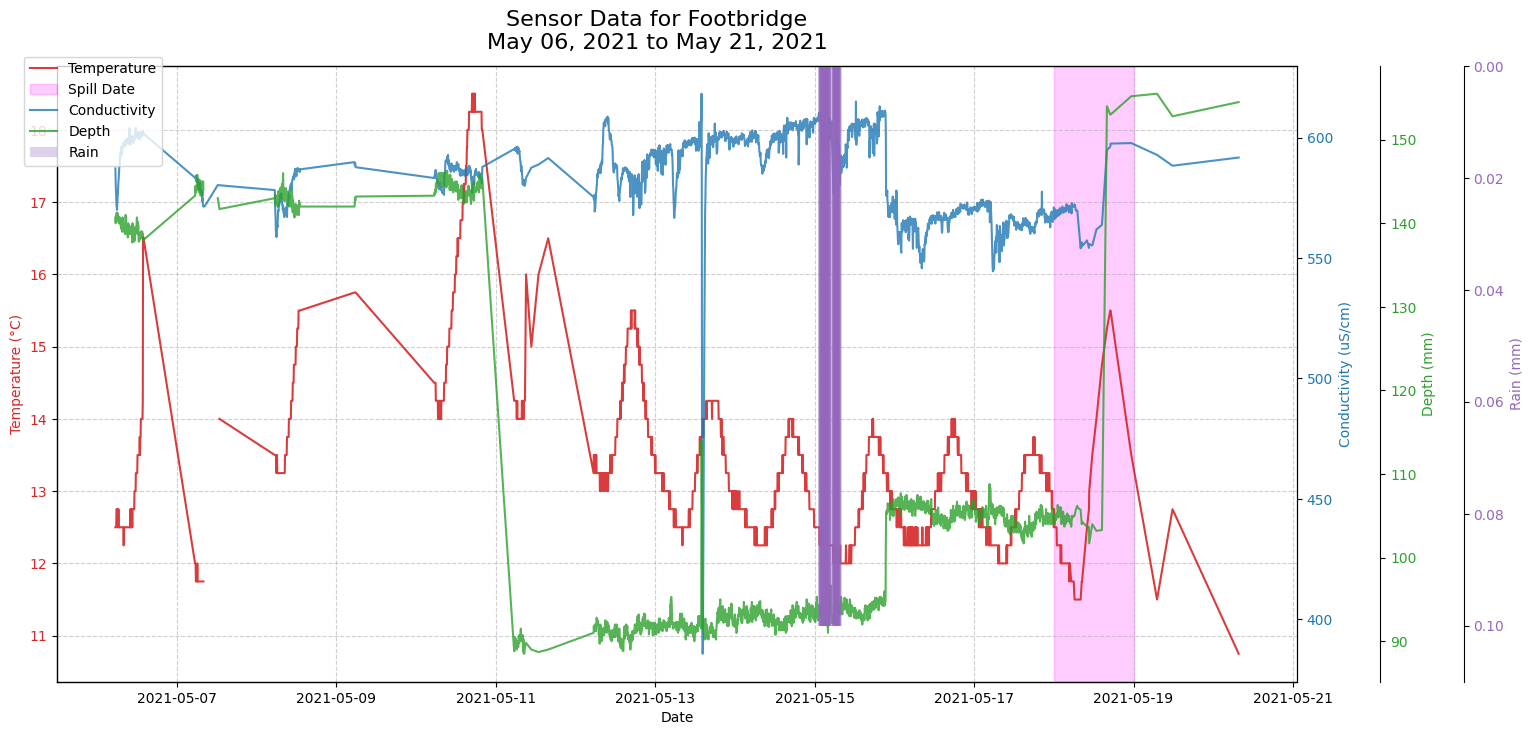

In [10]:
plot_date_range(
    df=rain_joined_MMW,
    location='footbridge',
    start_date='2021-05-06',
    end_date='2021-05-21',# This will create the magenta shaded area
    spill_event = '2021-05-18'
)

label spill/normal data

In [11]:
import pandas as pd

def label_events(df):
    """
    Creates a new 'event' column to label data based on predefined time windows.

    - 1: Spill
    - 0: Clean
    - -1: Anomaly/Exclude
    """
    # Ensure datetime column is in the correct format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize the event column with a default "clean" label
    df['event'] = 0

    # Define the time windows
    # Note: Corrected the end date for the anomaly
    event_windows = {
        'spill': ('2021-05-18 08:30', '2021-05-21 18:50'),
        'anomaly': ('2021-05-13 14:00', '2021-05-13 15:10'),
        'confirmed_clean': ('2021-05-06 09:30', '2021-05-18 00:15')
    }

    # Apply labels based on the windows
    spill_start, spill_end = pd.to_datetime(event_windows['spill'])
    anomaly_start, anomaly_end = pd.to_datetime(event_windows['anomaly'])

    df.loc[(df['datetime'] >= spill_start) & (df['datetime'] <= spill_end), 'event'] = 1
    df.loc[(df['datetime'] >= anomaly_start) & (df['datetime'] <= anomaly_end), 'event'] = -1

    print("Data labeling complete.")
    print(df['event'].value_counts())
    return df
labeled_df_spill_1 = label_events(rain_joined_MMW)

Data labeling complete.
event
 0    386982
-1        30
 1        16
Name: count, dtype: int64


Feature Engineering

In [12]:
## MODIFIED FEATURE ENGINEERING FUNCTION ##

def create_features(df, feature_cols, horizon=1, window_sizes=[3, 6, 12, 24]):
    """
    Engineers time-series features with a prediction horizon.
    """
    print(f"Creating features with a horizon of {horizon} steps...")
    df_features = df.copy()
    df_features = df_features.sort_values(['location', 'datetime'])

    # Group once to apply shifts efficiently
    grouped = df_features.groupby('location')

    for col in feature_cols:
        # Shift the original column by the horizon first
        series = grouped[col].shift(horizon)
        for window in window_sizes:
            # All features are now calculated on the shifted series
            df_features[f'{col}_lag_{window}'] = grouped[col].shift(window + horizon)
            rolling_window = series.rolling(window=window)
            df_features[f'{col}_roll_mean_{window}'] = rolling_window.mean()
            df_features[f'{col}_roll_std_{window}'] = rolling_window.std()

    # Important: Re-align index if it was changed by rolling operations
    df_features = df_features.reset_index(drop=True)
    return df_features

Making Regresiions normal behvioar

In [13]:
from sklearn.linear_model import Ridge

def train_sensor_model(df, feature_cols, target_col='conductivity'):
    """
    Trains a model to predict normal sensor values using only clean data.
    """
    print(f"Training a model to predict normal '{target_col}' values...")

    # Train ONLY on data labeled as 'clean' (event == 0)
    clean_df = df[df['event'] == 0].dropna(subset=feature_cols + [target_col])

    X_train = clean_df[feature_cols]
    y_train = clean_df[target_col]

    # A simple Ridge regression model is fast and effective
    sensor_model = Ridge(alpha=1.0)
    sensor_model.fit(X_train, y_train)

    print("Sensor prediction model trained.")
    return sensor_model

# --- How to use it ---
# # Define predictors for your sensor model
#sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
# # Train the model
#conductivity_model = train_sensor_model(featured_df, sensor_model_features)
# # Use it to predict expected values for the WHOLE dataset
#all_predictions = conductivity_model.predict(featured_df[sensor_model_features])
#featured_df['predicted_conductivity'] = all_predictions

optuna objective function

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
import optuna
import numpy as np

def cascading_objective(trial, df):
    """
    Cascading metrics objective function for Optuna optimization:
    1st: Catch spill +1000 points (must detect spill events)
    2nd: Minimize false alarms (70% remaining weight)  
    3rd: Catch spill fast (30% remaining weight)
    """
    # --- 1. Define the search space for parameters ---
    horizon = trial.suggest_int('horizon', 4, 12) # e.g., 1 to 12 steps (5 to 60 minutes)
    threshold_multiplier = trial.suggest_float('threshold_multiplier', 1.5, 5.0)

    # --- Original hyperparameters ---
    n_components = trial.suggest_int('n_components', 5, 20)
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    # --- 2. Create features using the suggested horizon ---
    feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    featured_df = create_features(df, feature_columns, horizon=horizon)
    featured_df.dropna(inplace=True) # Drop NaNs from feature creation

    # --- 3. Create the sensor anomaly feature (matching original implementation exactly) ---
    sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    target_sensor = 'conductivity'

    # Train sensor model (matching original function signature)
    sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
    predicted_values = sensor_model.predict(featured_df[sensor_model_features])
    
    # Calculate the error (residual)
    error = (featured_df[target_sensor] - predicted_values).abs()
    error_std = error.std() # Standard deviation of the error

    # Flag anomalies based on the optimized threshold
    featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

    # --- 4. Prepare data for final classification (EXACTLY like original) ---
    model_df = featured_df[featured_df['event'] != -1].copy()
    
    y = model_df['event']
    # Add our new 'sensor_anomaly' feature to the model's inputs
    X = model_df.drop(columns=['datetime', 'location', 'event'])

    if len(X) == 0 or len(np.unique(y)) < 2:
        return -1000  # Penalty if insufficient data or no class diversity

    # --- 5. Build and evaluate the final pipeline (EXACTLY like original) ---
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
    ])

    # Train and predict on FULL dataset (like original - no train/test split)
    pipeline.fit(X, y)
    preds = pipeline.predict(X)
    pred_proba = pipeline.predict_proba(X)[:, 1] if len(np.unique(y)) > 1 else np.zeros(len(X))

    # --- 6. CASCADING METRICS CALCULATION ---
    
    # Convert to binary for metrics calculation: 0=clean, 1=spill
    y_binary = (y > 0).astype(int)
    preds_binary = (preds > 0).astype(int)
    
    # Calculate basic metrics
    recall = recall_score(y_binary, preds_binary, zero_division=0)  # Spill detection rate
    precision = precision_score(y_binary, preds_binary, zero_division=0)  # Precision (1 - false positive rate)
    accuracy = accuracy_score(y_binary, preds_binary)
    
    # **METRIC 1: Catch spill +1000 points**
    # If we fail to detect ANY spill events, major penalty
    if recall < 0.1:  # Less than 10% spill detection
        return -1000
    
    # Base score for detecting spills
    spill_detection_bonus = 1000 * recall
    
    # **METRIC 2: Minimize false alarms (70% of remaining weight)**
    # False positive rate = 1 - precision (when we predict spill but it's actually clean)
    false_positive_rate = 1 - precision if precision > 0 else 1.0
    false_alarm_penalty = -700 * false_positive_rate  # 70% weight, negative because we want to minimize
    
    # **METRIC 3: Catch spill fast (30% of remaining weight)**
    # Time to detection: calculate how quickly we detect spills
    # We'll use the prediction probabilities as a proxy for "confidence/speed"
    # Higher average probability on true spill events = faster/more confident detection
    spill_indices = (y_binary == 1)
    if np.sum(spill_indices) > 0 and len(pred_proba) > 0:
        avg_spill_confidence = np.mean(pred_proba[spill_indices])
        speed_bonus = 300 * avg_spill_confidence  # 30% weight
    else:
        speed_bonus = 0
    
    # **FINAL CASCADING SCORE**
    final_score = spill_detection_bonus + false_alarm_penalty + speed_bonus
    
    # Optional: Add small accuracy bonus if all metrics are good
    if recall > 0.8 and precision > 0.8:
        final_score += 100 * accuracy
    
    return final_score

def objective(trial, df):
    """
    Original objective function using F1 score (kept for comparison).
    """
    # --- 1. Define the search space for our new parameters ---
    horizon = trial.suggest_int('horizon', 2, 12) # e.g., 1 to 12 steps (5 to 60 minutes)
    threshold_multiplier = trial.suggest_float('threshold_multiplier', 1.5, 5.0)

    # --- Original hyperparameters ---
    n_components = trial.suggest_int('n_components', 5, 20)
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    # --- 2. Create features using the suggested horizon ---
    feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    featured_df = create_features(df, feature_columns, horizon=horizon)
    featured_df.dropna(inplace=True) # Drop NaNs from feature creation

    # --- 3. Create the sensor anomaly feature ---
    sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    target_sensor = 'conductivity'

    # (For speed, you could pre-train this model once outside the loop)
    sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
    predicted_values = sensor_model.predict(featured_df[sensor_model_features])
    
    # Calculate the error (residual)
    error = (featured_df[target_sensor] - predicted_values).abs()
    error_std = error.std() # Standard deviation of the error

    # Flag anomalies based on the optimized threshold
    featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

    # --- 4. Prepare data for the final spill classification model ---
    model_df = featured_df[featured_df['event'] != -1].copy()
    
    y = model_df['event']
    # Add our new 'sensor_anomaly' feature to the model's inputs
    X = model_df.drop(columns=['datetime', 'location', 'event'])

    # --- 5. Build and evaluate the final pipeline ---
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
    ])

    pipeline.fit(X, y)
    preds = pipeline.predict(X)
    score = f1_score(y, preds, average='macro')

    return score

# 🎯 CASCADING METRICS OBJECTIVE FUNCTION\n\nThis notebook implements a **cascading metrics objective function** for Optuna optimization with the following priorities:\n\n## Cascading Metrics Breakdown:\n\n**1st Priority: Catch Spill Events (+1000 points)**\n- Must detect spill events (recall > 10% minimum)\n- Base score = 1000 × recall rate\n- If recall < 10%, return -1000 penalty\n\n**2nd Priority: Minimize False Alarms (70% remaining weight)**\n- Penalty = -700 × false positive rate\n- False positive rate = 1 - precision\n- 70% weight on minimizing false alarms\n\n**3rd Priority: Catch Spill Fast (30% remaining weight)**\n- Bonus = 300 × average spill confidence\n- Uses prediction probabilities as proxy for detection speed\n- 30% weight on fast/confident detection\n\n**Bonus: Overall Performance**\n- If recall > 80% AND precision > 80%: +100 × accuracy\n\n## Key Benefits:\n- Ensures spill detection is prioritized over accuracy\n- Balances false alarm reduction with detection speed\n- Provides interpretable, domain-specific optimization"

In [15]:
# === CASCADING METRICS OPTUNA OPTIMIZATION ===
# New optimization using cascading metrics objective function

print("=== Running Cascading Metrics Optimization ===")
print("Objective Function Breakdown:")
print("1st: Catch spill +1000 points (must detect spill events)")
print("2nd: Minimize false alarms (70% remaining weight)")  
print("3rd: Catch spill fast (30% remaining weight)")
print()

# Create new study for cascading metrics
cascading_study = optuna.create_study(direction='maximize')
cascading_study.optimize(lambda trial: cascading_objective(trial, labeled_df_spill_1), n_trials=20)

print(f"\n=== CASCADING METRICS RESULTS ===")
print(f"Best trial score: {cascading_study.best_value}")
print(f"Best trial params: {cascading_study.best_params}")

# Store the results for comparison
cascading_best_params = cascading_study.best_params
cascading_best_score = cascading_study.best_value

[I 2025-08-12 20:10:37,904] A new study created in memory with name: no-name-f9acfe2f-0f60-4a05-906f-ed97c79f1d3c


=== Running Cascading Metrics Optimization ===
Objective Function Breakdown:
1st: Catch spill +1000 points (must detect spill events)
2nd: Minimize false alarms (70% remaining weight)
3rd: Catch spill fast (30% remaining weight)

Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:10:42,797] Trial 0 finished with value: -1000.0 and parameters: {'horizon': 11, 'threshold_multiplier': 4.056157797338548, 'n_components': 10, 'C': 7.431397639959616}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:10:50,111] Trial 1 finished with value: 963.6594472393667 and parameters: {'horizon': 10, 'threshold_multiplier': 2.925344583394307, 'n_components': 19, 'C': 35.008162735403936}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 5 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:10:54,293] Trial 2 finished with value: -1000.0 and parameters: {'horizon': 5, 'threshold_multiplier': 3.9705856448585863, 'n_components': 10, 'C': 0.019647929202979}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:10:58,940] Trial 3 finished with value: -1000.0 and parameters: {'horizon': 7, 'threshold_multiplier': 4.527735336907529, 'n_components': 15, 'C': 0.2588666067642843}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:05,440] Trial 4 finished with value: 654.3697394585881 and parameters: {'horizon': 11, 'threshold_multiplier': 4.725236275472013, 'n_components': 15, 'C': 45.28635088280057}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:09,508] Trial 5 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 1.5939573200697552, 'n_components': 14, 'C': 0.00012907468315583943}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:13,531] Trial 6 finished with value: -1000.0 and parameters: {'horizon': 11, 'threshold_multiplier': 4.600159625741884, 'n_components': 9, 'C': 0.0014094239022019242}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:17,858] Trial 7 finished with value: -1000.0 and parameters: {'horizon': 6, 'threshold_multiplier': 3.7231105333440535, 'n_components': 16, 'C': 0.013263077297474718}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:22,239] Trial 8 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 1.6211596133478448, 'n_components': 14, 'C': 0.11089252594833454}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:26,676] Trial 9 finished with value: -1000.0 and parameters: {'horizon': 9, 'threshold_multiplier': 3.0409678573876353, 'n_components': 17, 'C': 0.008106759763405743}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:33,411] Trial 10 finished with value: 189.73861834808963 and parameters: {'horizon': 9, 'threshold_multiplier': 2.4029037287443007, 'n_components': 20, 'C': 1.8017541303122586}. Best is trial 1 with value: 963.6594472393667.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:41,368] Trial 11 finished with value: 1197.369284513494 and parameters: {'horizon': 9, 'threshold_multiplier': 2.9504865786952315, 'n_components': 20, 'C': 86.0335793811483}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:48,256] Trial 12 finished with value: 749.6531711319966 and parameters: {'horizon': 9, 'threshold_multiplier': 2.8921410476073115, 'n_components': 20, 'C': 33.264318833330265}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:52,424] Trial 13 finished with value: -1000.0 and parameters: {'horizon': 8, 'threshold_multiplier': 2.3172996892127524, 'n_components': 6, 'C': 2.148684731689193}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:11:59,499] Trial 14 finished with value: 1195.4279987767195 and parameters: {'horizon': 10, 'threshold_multiplier': 3.3850905011831562, 'n_components': 18, 'C': 59.93918093557566}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:12:08,246] Trial 15 finished with value: 800.2343996879563 and parameters: {'horizon': 7, 'threshold_multiplier': 3.4980515668604246, 'n_components': 18, 'C': 92.92530545715938}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:12:13,223] Trial 16 finished with value: -1000.0 and parameters: {'horizon': 4, 'threshold_multiplier': 2.6467265025921916, 'n_components': 12, 'C': 4.313609204836798}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:12:18,367] Trial 17 finished with value: -1000.0 and parameters: {'horizon': 10, 'threshold_multiplier': 3.342456601192136, 'n_components': 18, 'C': 0.48457844941191264}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:12:24,230] Trial 18 finished with value: 376.2778577525908 and parameters: {'horizon': 8, 'threshold_multiplier': 4.16001212718151, 'n_components': 17, 'C': 8.7740540858187}. Best is trial 11 with value: 1197.369284513494.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:12:31,144] Trial 19 finished with value: 745.1574611238237 and parameters: {'horizon': 10, 'threshold_multiplier': 2.083372377968094, 'n_components': 20, 'C': 16.039404308268317}. Best is trial 11 with value: 1197.369284513494.



=== CASCADING METRICS RESULTS ===
Best trial score: 1197.369284513494
Best trial params: {'horizon': 9, 'threshold_multiplier': 2.9504865786952315, 'n_components': 20, 'C': 86.0335793811483}


In [16]:
# === BUILD FINAL MODEL WITH CASCADING METRICS PARAMETERS ===

print("=== Building Final Model with Cascading Metrics Parameters ===")

# Use the best parameters from cascading optimization
best_params = cascading_best_params
print(f"Using cascading metrics parameters: {best_params}")

# Recreate the dataset with optimal parameters
horizon = best_params['horizon']
threshold_multiplier = best_params['threshold_multiplier']
n_components = best_params['n_components']
C = best_params['C']

print(f"Step 1: Creating features with horizon={horizon}...")
feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
featured_df = create_features(labeled_df_spill_1, feature_columns, horizon=horizon)
featured_df.dropna(inplace=True)

print(f"Step 2: Training sensor model and adding anomaly features...")
sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
target_sensor = 'conductivity'
sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
predicted_values = sensor_model.predict(featured_df[sensor_model_features])
error = (featured_df[target_sensor] - predicted_values).abs()
error_std = error.std()
featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

print(f"Step 3: Training final classification model...")
model_df = featured_df[featured_df['event'] != -1].copy()
y = model_df['event']
X = model_df.drop(columns=['datetime', 'location', 'event'])

# Build the final pipeline with optimal parameters
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
])

final_pipeline.fit(X, y)
final_predictions = final_pipeline.predict(X)

# Create results dataframe for plotting
results_df = featured_df.copy()
results_df['predicted_event'] = -1  # Initialize all as -1
mask = results_df['event'] != -1
results_df.loc[mask, 'predicted_event'] = final_predictions

# Rename event column to true_event for plotting function
results_df['true_event'] = results_df['event']

print(f"Final model performance summary:")
model_mask = results_df['event'] != -1
y_true_binary = (results_df.loc[model_mask, 'true_event'] > 0).astype(int)
y_pred_binary = (results_df.loc[model_mask, 'predicted_event'] > 0).astype(int)

final_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
final_precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
final_accuracy = accuracy_score(y_true_binary, y_pred_binary)
final_f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

print(f"  Spill Detection Rate (Recall): {final_recall:.4f}")
print(f"  Precision (1 - False Alarm Rate): {final_precision:.4f}")
print(f"  Accuracy: {final_accuracy:.4f}")
print(f"  F1 Score: {final_f1:.4f}")

print(f"\\nReady for plotting! Use the results_df dataframe.")
print(f"Results dataframe shape: {results_df.shape}")
print(f"Columns: {list(results_df.columns)}")

=== Building Final Model with Cascading Metrics Parameters ===
Using cascading metrics parameters: {'horizon': 9, 'threshold_multiplier': 2.9504865786952315, 'n_components': 20, 'C': 86.0335793811483}
Step 1: Creating features with horizon=9...
Creating features with a horizon of 9 steps...
Step 2: Training sensor model and adding anomaly features...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.
Step 3: Training final classification model...
Final model performance summary:
  Spill Detection Rate (Recall): 0.8750
  Precision (1 - False Alarm Rate): 1.0000
  Accuracy: 1.0000
  F1 Score: 0.9333
\nReady for plotting! Use the results_df dataframe.
Results dataframe shape: (330203, 125)
Columns: ['datetime', 'location', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg', 'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max', 'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Av

=== Plotting Cascading Metrics Results ===
Generating cascading metrics plot...


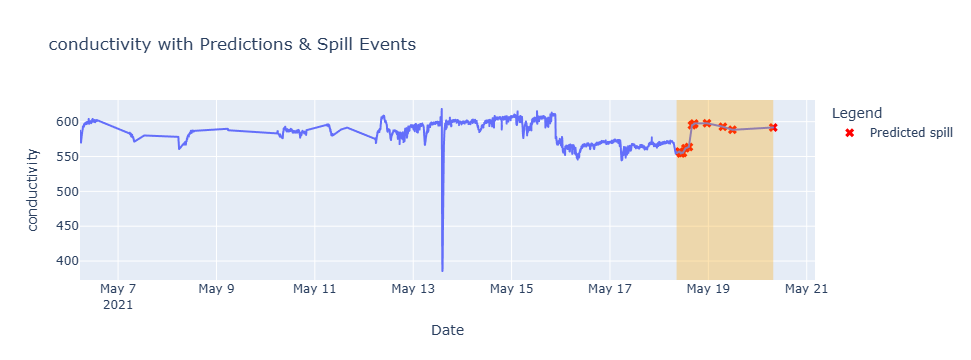

\nCascading metrics plot generated!
\nPlot features:
- Blue line: Conductivity sensor data
- Red X markers: Predicted spill events (cascading metrics)
- Orange shaded area: True spill events
- Interactive hover for details
\n=== CASCADING METRICS ANALYSIS ===
Optimization focused on:
1st Priority: Catch spill events (+1000 points)
2nd Priority: Minimize false alarms (70% weight)
3rd Priority: Fast detection (30% weight)
\nFinal optimized parameters:
  horizon: 9
  threshold_multiplier: 2.9504865786952315
  n_components: 20
  C: 86.0335793811483
\nFinal cascading score: 1197.37


In [17]:
# === PLOT CASCADING METRICS RESULTS ===
import plotly.express as px
import plotly.graph_objects as go
print("=== Plotting Cascading Metrics Results ===")

# Use the existing plot_model_predictions function with results_df
print("Generating cascading metrics plot...")

plot_model_predictions(
    df=results_df,
    location='footbridge',  # Spill 1 location
    start_date='2021-05-06',
    end_date='2021-05-21',
    sensor='conductivity'
)

print("\\nCascading metrics plot generated!")
print("\\nPlot features:")
print("- Blue line: Conductivity sensor data")
print("- Red X markers: Predicted spill events (cascading metrics)")
print("- Orange shaded area: True spill events")
print("- Interactive hover for details")

# Additional analysis
print(f"\\n=== CASCADING METRICS ANALYSIS ===")
print(f"Optimization focused on:")
print(f"1st Priority: Catch spill events (+1000 points)")
print(f"2nd Priority: Minimize false alarms (70% weight)")
print(f"3rd Priority: Fast detection (30% weight)")
print(f"\\nFinal optimized parameters:")
for param, value in cascading_best_params.items():
    print(f"  {param}: {value}")
print(f"\\nFinal cascading score: {cascading_best_score:.2f}")

# Compare with original F1-score results if available
if 'study' in locals():
    print(f"\\n=== COMPARISON ===")
    print(f"Original F1-Score Best: {study.best_value:.6f}")
    print(f"Cascading Metrics Best: {cascading_best_score:.2f}")
    print(f"\\nThe cascading approach prioritizes spill detection over overall F1 score.")

plot results

# Spill 2

In [18]:
# Define the start and end timestamps
start_date = '2023-02-13 12:55'
end_date = '2023-06-15 3:40'

# Filter the DataFrame
filtered_df_MMW = rain_joined_MMW[
    (rain_joined_MMW['location'] == 'grinnel') &
    (rain_joined_MMW['datetime'].between(start_date, end_date))
]

# Display the first few rows of the result
filtered_df_MMW.head(2)

,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature,event
126806,2023-02-13 12:55:00,grinnel,979.9531,-0.889,42.4,58.8,59.79,57.64,58.35,59.24,...,3.984,3.698,639.5,0.0,550.0,109.0,380.3,4.139,15.4,0
126807,2023-02-13 13:00:00,grinnel,979.9531,-0.889,42.4,58.8,59.79,57.64,58.35,59.24,...,3.984,3.698,639.5,0.0,550.3,109.0,373.8,4.139,15.4,0


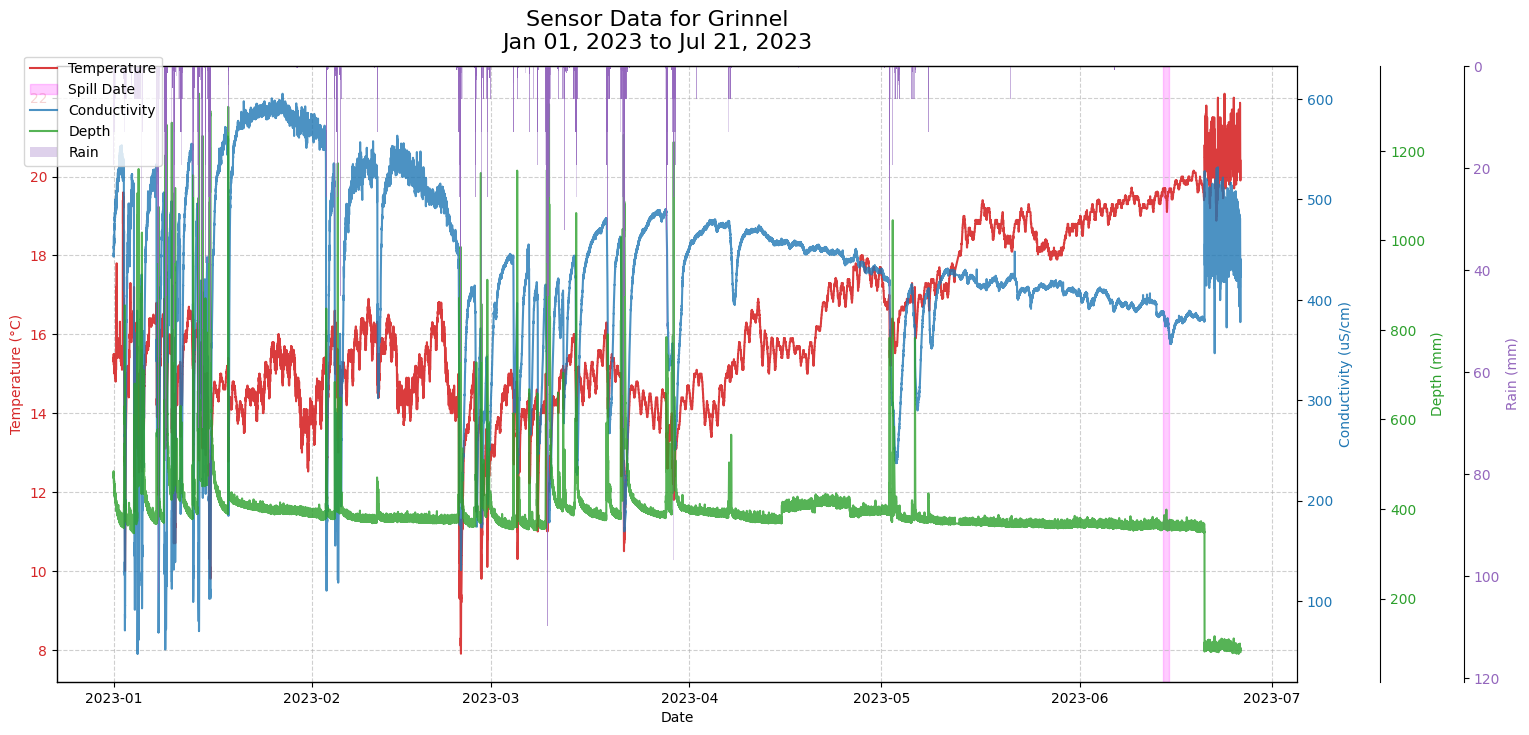

In [19]:
plot_date_range(
    df=rain_joined_MMW,
    location='grinnel',
    start_date='2023-01-01',
    end_date='2023-07-21',# This will create the magenta shaded area
    spill_event = '2023-06-14'
)

In [30]:
# === CREATE PROPERLY FILTERED SPILL 2 DATASET ===

print("=== Creating Filtered Spill 2 Dataset ===")

# Filter labeled_df_spill_1 for Spill 2 analysis:
# - Location: grinnel only
# - Time period: Include the actual spill event dates
spill2_start = '2023-02-13'
spill2_end = '2023-06-15'  # Extended to include spill event (June 14-15)

print(f"Filtering data for:")
print(f"  Location: grinnel")
print(f"  Date range: {spill2_start} to {spill2_end}")

# Create filtered dataset for Spill 2
labeled_df_spill_2 = labeled_df_spill_1[
    (labeled_df_spill_1['location'] == 'grinnel') &
    (labeled_df_spill_1['datetime'] >= spill2_start) &
    (labeled_df_spill_1['datetime'] <= spill2_end)
].copy()

print(f"\\nFiltered Spill 2 dataset:")
print(f"  Total rows: {len(labeled_df_spill_2)}")
print(f"  Date range: {labeled_df_spill_2['datetime'].min()} to {labeled_df_spill_2['datetime'].max()}")
print(f"  Locations: {labeled_df_spill_2['location'].unique()}")

# Check event distribution in filtered data
print(f"\\nEvent distribution in filtered Spill 2 data:")
print(labeled_df_spill_2['event'].value_counts().sort_index())

# Check for spill events specifically
spill_events = labeled_df_spill_2[labeled_df_spill_2['event'] == 1]
print(f"\\nSpill events (event=1): {len(spill_events)}")
if len(spill_events) > 0:
    print(f"Spill event date range:")
    print(f"  From: {spill_events['datetime'].min()}")
    print(f"  To: {spill_events['datetime'].max()}")
else:
    print("⚠️  NO SPILL EVENTS IN FILTERED DATA!")
    
print(f"\\n✅ Spill 2 dataset ready: use 'labeled_df_spill_2' for optimization")

=== Creating Filtered Spill 2 Dataset ===
Filtering data for:
  Location: grinnel
  Date range: 2023-02-13 to 2023-06-15
\nFiltered Spill 2 dataset:
  Total rows: 33448
  Date range: 2023-02-13 00:00:00 to 2023-06-15 00:00:00
  Locations: ['grinnel']
\nEvent distribution in filtered Spill 2 data:
event
0    33353
1       95
Name: count, dtype: int64
\nSpill events (event=1): 95
Spill event date range:
  From: 2023-06-14 12:55:00
  To: 2023-06-15 00:00:00
\n✅ Spill 2 dataset ready: use 'labeled_df_spill_2' for optimization


In [31]:
labeled_df_spill_1

,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature,event
0,2021-04-30 14:50:00,footbridge,987.4875,-5.088,47.72,57.93,60.06,56.56,56.77,61.86,...,4.280,3.785,714.40,0.0,0.0,90.0,-3.5,4.291,27.75,0
1,2021-04-30 14:55:00,footbridge,987.4875,-5.388,47.79,58.90,61.94,56.96,57.69,63.08,...,3.151,2.411,679.70,0.0,0.0,51.0,-3.3,4.230,27.75,0
2,2021-04-30 15:00:00,footbridge,987.4875,-5.388,47.79,58.90,61.94,56.96,57.69,63.08,...,3.151,2.411,679.70,0.0,0.0,90.0,-3.7,4.230,27.50,0
3,2021-04-30 17:35:00,grinnel,986.4113,-2.518,47.16,52.89,53.60,52.25,52.36,54.88,...,5.911,5.614,159.00,0.0,26.5,NaN,0.0,23.900,10.50,0
4,2021-04-30 18:00:00,grinnel,986.4538,-1.601,47.21,51.53,52.25,51.18,51.19,52.79,...,5.511,5.228,74.93,0.0,26.5,NaN,0.0,23.900,10.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,4.897,0.00,0.0,356.0,84.0,435.3,4.397,45.50,0
387024,2025-08-09 15:15:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,4.897,0.00,0.0,346.5,84.0,436.8,4.397,45.00,0
387025,2025-08-09 15:30:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,4.897,0.00,0.0,334.0,81.0,433.0,4.260,44.50,0
387026,2025-08-09 15:45:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,4.897,0.00,0.0,326.8,84.0,437.5,4.260,44.00,0


In [32]:
# === SPILL 2: CASCADING METRICS OPTIMIZATION ONLY ===

print("=== SPILL 2: CASCADING METRICS OPTIMIZATION ===")
print("Using FILTERED Spill 2 dataset (grinnel location, 2023 data only)")
print("Objective Function Breakdown:")
print("1st: Catch spill +1000 points (must detect spill events)")
print("2nd: Minimize false alarms (70% remaining weight)")  
print("3rd: Catch spill fast (30% remaining weight)")
print()

# Cascading metrics optimization for Spill 2 using FILTERED dataset
spill2_cascading_study = optuna.create_study(direction='maximize')
spill2_cascading_study.optimize(lambda trial: cascading_objective(trial, labeled_df_spill_2), n_trials=20)  # ✅ Using filtered data!

print(f"\nSpill 2 - Cascading Metrics Results:")
print(f"Best trial score: {spill2_cascading_study.best_value}")
print(f"Best trial params: {spill2_cascading_study.best_params}")

spill2_cascading_params = spill2_cascading_study.best_params
spill2_cascading_score = spill2_cascading_study.best_value

print("\n" + "="*60)
print("=== SPILL 2: CASCADING METRICS SUMMARY ===")
print("Cascading Metrics Optimization (Filtered Dataset):")
print(f"  Best Score: {spill2_cascading_score:.6f}")
print(f"  Best Params: {spill2_cascading_params}")

# Store the best cascading parameters for final model training
print("\nUsing CASCADING METRICS parameters for final Spill 2 model...")
spill2_best_params = spill2_cascading_params

=== SPILL 2: CASCADING METRICS OPTIMIZATION ===
Using FILTERED Spill 2 dataset (grinnel location, 2023 data only)
Objective Function Breakdown:
1st: Catch spill +1000 points (must detect spill events)
2nd: Minimize false alarms (70% remaining weight)
3rd: Catch spill fast (30% remaining weight)



[I 2025-08-12 20:15:44,714] A new study created in memory with name: no-name-2843704f-0308-490b-b6dd-4364b31a762f


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:45,232] Trial 0 finished with value: -1000.0 and parameters: {'horizon': 8, 'threshold_multiplier': 2.496164396581059, 'n_components': 10, 'C': 1.2685437234957293}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:45,645] Trial 1 finished with value: -1000.0 and parameters: {'horizon': 6, 'threshold_multiplier': 4.200508267155165, 'n_components': 7, 'C': 0.001952237086012057}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:46,067] Trial 2 finished with value: -1000.0 and parameters: {'horizon': 7, 'threshold_multiplier': 2.8549998198694713, 'n_components': 10, 'C': 0.00011920727052165868}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:46,655] Trial 3 finished with value: 426.6533418275078 and parameters: {'horizon': 11, 'threshold_multiplier': 4.6193798272952105, 'n_components': 14, 'C': 5.116686006460824}. Best is trial 3 with value: 426.6533418275078.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:47,133] Trial 4 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 3.0436418948102606, 'n_components': 18, 'C': 0.07173496887515592}. Best is trial 3 with value: 426.6533418275078.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:47,660] Trial 5 finished with value: -1000.0 and parameters: {'horizon': 11, 'threshold_multiplier': 1.8629515895001554, 'n_components': 16, 'C': 0.24571142218199452}. Best is trial 3 with value: 426.6533418275078.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:48,364] Trial 6 finished with value: 1129.0838314346593 and parameters: {'horizon': 12, 'threshold_multiplier': 2.8377484142493055, 'n_components': 17, 'C': 72.88599270170342}. Best is trial 6 with value: 1129.0838314346593.


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:48,897] Trial 7 finished with value: 136.9184216985907 and parameters: {'horizon': 8, 'threshold_multiplier': 2.4034773964813265, 'n_components': 15, 'C': 2.3918601825452774}. Best is trial 6 with value: 1129.0838314346593.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:49,382] Trial 8 finished with value: -1000.0 and parameters: {'horizon': 11, 'threshold_multiplier': 2.530880863124059, 'n_components': 18, 'C': 0.05068183567302502}. Best is trial 6 with value: 1129.0838314346593.


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:50,045] Trial 9 finished with value: 762.5717065001849 and parameters: {'horizon': 7, 'threshold_multiplier': 2.9866379663811324, 'n_components': 17, 'C': 13.855221391006829}. Best is trial 6 with value: 1129.0838314346593.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:51,128] Trial 10 finished with value: 1332.6220310550846 and parameters: {'horizon': 9, 'threshold_multiplier': 3.756249421405835, 'n_components': 20, 'C': 59.15371072159152}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:51,903] Trial 11 finished with value: 1284.7156556290136 and parameters: {'horizon': 4, 'threshold_multiplier': 3.8520267813581572, 'n_components': 20, 'C': 84.8722303582219}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:52,660] Trial 12 finished with value: 1286.6557708899402 and parameters: {'horizon': 4, 'threshold_multiplier': 3.8802707221483494, 'n_components': 20, 'C': 90.4420871138323}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:53,346] Trial 13 finished with value: 1200.033511113557 and parameters: {'horizon': 4, 'threshold_multiplier': 3.716411720636062, 'n_components': 20, 'C': 21.74012459281662}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:53,876] Trial 14 finished with value: -1000.0 and parameters: {'horizon': 9, 'threshold_multiplier': 4.968792230820581, 'n_components': 13, 'C': 0.46172895612272713}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 5 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:54,375] Trial 15 finished with value: -1000.0 and parameters: {'horizon': 5, 'threshold_multiplier': 3.6058808187967526, 'n_components': 20, 'C': 0.013119224417028081}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:54,940] Trial 16 finished with value: 143.77044898605328 and parameters: {'horizon': 9, 'threshold_multiplier': 4.2458480126400024, 'n_components': 11, 'C': 18.750382165382902}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:55,417] Trial 17 finished with value: -1000.0 and parameters: {'horizon': 9, 'threshold_multiplier': 3.437344574555735, 'n_components': 6, 'C': 82.26584089963539}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:56,094] Trial 18 finished with value: 696.9626418448404 and parameters: {'horizon': 6, 'threshold_multiplier': 4.091293656649039, 'n_components': 19, 'C': 7.58964144225855}. Best is trial 10 with value: 1332.6220310550846.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 20:15:56,698] Trial 19 finished with value: -1000.0 and parameters: {'horizon': 10, 'threshold_multiplier': 4.635094403073826, 'n_components': 16, 'C': 1.5202481597353021}. Best is trial 10 with value: 1332.6220310550846.



Spill 2 - Cascading Metrics Results:
Best trial score: 1332.6220310550846
Best trial params: {'horizon': 9, 'threshold_multiplier': 3.756249421405835, 'n_components': 20, 'C': 59.15371072159152}

=== SPILL 2: CASCADING METRICS SUMMARY ===
Cascading Metrics Optimization (Filtered Dataset):
  Best Score: 1332.622031
  Best Params: {'horizon': 9, 'threshold_multiplier': 3.756249421405835, 'n_components': 20, 'C': 59.15371072159152}

Using CASCADING METRICS parameters for final Spill 2 model...


=== Creating Filtered Spill 2 Dataset ===
Filtering data for:
  Location: grinnel
  Date range: 2023-02-13 to 2023-06-15
\nFiltered Spill 2 dataset:
  Total rows: 33448
  Date range: 2023-02-13 00:00:00 to 2023-06-15 00:00:00
  Locations: ['grinnel']
\nEvent distribution in filtered Spill 2 data:
event
0    33353
1       95
Name: count, dtype: int64
\nSpill events (event=1): 95
Spill event date range:
  From: 2023-06-14 12:55:00
  To: 2023-06-15 00:00:00
\n✅ Spill 2 dataset ready: use 'labeled_df_spill_2' for optimization


In [28]:
labeled_df_spill_2

,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature,event
126651,2023-02-13 00:00:00,grinnel,980.2850,1.313,33.49,56.29,60.43,49.66,57.51,56.20,...,2.950,2.382,0.001,0.0,515.3,109.0,373.3,4.109,16.30,0
126652,2023-02-13 00:05:00,grinnel,980.2850,1.313,33.49,56.29,60.43,49.66,57.51,56.20,...,2.950,2.382,0.001,0.0,514.5,109.0,372.2,4.109,16.30,0
126653,2023-02-13 00:10:00,grinnel,980.0588,1.278,39.31,51.93,57.47,48.84,52.98,51.70,...,3.049,2.772,0.008,0.0,513.7,109.0,373.0,4.109,16.30,0
126654,2023-02-13 00:15:00,grinnel,980.0588,1.278,39.31,51.93,57.47,48.84,52.98,51.70,...,3.049,2.772,0.008,0.0,514.7,109.0,382.3,4.109,16.40,0
126655,2023-02-13 00:20:00,grinnel,980.0588,1.278,39.31,51.93,57.47,48.84,52.98,51.70,...,3.049,2.772,0.008,0.0,515.7,109.0,374.0,4.109,16.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160094,2023-06-14 23:25:00,grinnel,979.4008,-0.072,49.09,51.63,51.78,51.38,51.48,51.55,...,3.165,2.945,0.000,0.0,365.2,109.0,354.7,4.109,19.62,1
160095,2023-06-14 23:40:00,grinnel,979.4008,-0.089,49.10,51.71,52.05,51.51,51.56,51.65,...,3.036,2.763,0.000,0.0,366.0,71.0,364.2,4.109,19.70,1
160096,2023-06-14 23:45:00,grinnel,979.4008,-0.089,49.10,51.71,52.05,51.51,51.56,51.65,...,3.036,2.763,0.000,0.0,365.2,71.0,356.8,4.109,19.70,1
160097,2023-06-14 23:55:00,grinnel,979.6700,-0.130,49.24,51.86,52.05,51.51,51.64,51.77,...,3.261,2.996,0.000,0.0,365.2,109.0,362.0,4.109,19.70,1


In [33]:
# === SPILL 2: BUILD FINAL MODEL WITH CASCADING METRICS PARAMETERS ===

print("=== Building Final Spill 2 Model with Cascading Metrics Parameters ===")

# Use the best parameters from Spill 2 cascading optimization
best_params_s2 = spill2_best_params
print(f"Using Spill 2 cascading metrics parameters: {best_params_s2}")

# Recreate the dataset with optimal parameters for Spill 2
horizon_s2 = best_params_s2['horizon']
threshold_multiplier_s2 = best_params_s2['threshold_multiplier']
n_components_s2 = best_params_s2['n_components']
C_s2 = best_params_s2['C']

print(f"Step 1: Creating Spill 2 features with horizon={horizon_s2}...")
feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
featured_df_s2 = create_features(labeled_df_spill_2, feature_columns, horizon=horizon_s2)  # ✅ Using filtered data!
featured_df_s2.dropna(inplace=True)

print(f"Step 2: Training Spill 2 sensor model and adding anomaly features...")
sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
target_sensor = 'conductivity'
sensor_model_s2 = train_sensor_model(featured_df_s2, sensor_model_features, target_col=target_sensor)
predicted_values_s2 = sensor_model_s2.predict(featured_df_s2[sensor_model_features])
error_s2 = (featured_df_s2[target_sensor] - predicted_values_s2).abs()
error_std_s2 = error_s2.std()
featured_df_s2['sensor_anomaly'] = (error_s2 > (error_std_s2 * threshold_multiplier_s2)).astype(int)

print(f"Step 3: Training final Spill 2 classification model...")
model_df_s2 = featured_df_s2[featured_df_s2['event'] != -1].copy()
y_s2 = model_df_s2['event']
X_s2 = model_df_s2.drop(columns=['datetime', 'location', 'event'])

# Build the final pipeline with optimal parameters for Spill 2
final_pipeline_s2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_s2)),
    ('model', LogisticRegression(C=C_s2, random_state=42, solver='liblinear'))
])

final_pipeline_s2.fit(X_s2, y_s2)
final_predictions_s2 = final_pipeline_s2.predict(X_s2)

# Create results dataframe for Spill 2 plotting
results_df_spill2 = featured_df_s2.copy()
results_df_spill2['predicted_event'] = -1  # Initialize all as -1
mask_s2 = results_df_spill2['event'] != -1
results_df_spill2.loc[mask_s2, 'predicted_event'] = final_predictions_s2

# Rename event column to true_event for plotting function
results_df_spill2['true_event'] = results_df_spill2['event']

print(f"Spill 2 final model performance summary:")
model_mask_s2 = results_df_spill2['event'] != -1
y_true_binary_s2 = (results_df_spill2.loc[model_mask_s2, 'true_event'] > 0).astype(int)
y_pred_binary_s2 = (results_df_spill2.loc[model_mask_s2, 'predicted_event'] > 0).astype(int)

final_recall_s2 = recall_score(y_true_binary_s2, y_pred_binary_s2, zero_division=0)
final_precision_s2 = precision_score(y_true_binary_s2, y_pred_binary_s2, zero_division=0)
final_accuracy_s2 = accuracy_score(y_true_binary_s2, y_pred_binary_s2)
final_f1_s2 = f1_score(y_true_binary_s2, y_pred_binary_s2, zero_division=0)

print(f"  Spill Detection Rate (Recall): {final_recall_s2:.4f}")
print(f"  Precision (1 - False Alarm Rate): {final_precision_s2:.4f}")
print(f"  Accuracy: {final_accuracy_s2:.4f}")
print(f"  F1 Score: {final_f1_s2:.4f}")

print(f"\\nSpill 2 ready for plotting! Use the results_df_spill2 dataframe.")
print(f"Spill 2 results dataframe shape: {results_df_spill2.shape}")
print(f"Columns: {list(results_df_spill2.columns)}")

=== Building Final Spill 2 Model with Cascading Metrics Parameters ===
Using Spill 2 cascading metrics parameters: {'horizon': 9, 'threshold_multiplier': 3.756249421405835, 'n_components': 20, 'C': 59.15371072159152}
Step 1: Creating Spill 2 features with horizon=9...
Creating features with a horizon of 9 steps...
Step 2: Training Spill 2 sensor model and adding anomaly features...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.
Step 3: Training final Spill 2 classification model...
Spill 2 final model performance summary:
  Spill Detection Rate (Recall): 0.9789
  Precision (1 - False Alarm Rate): 1.0000
  Accuracy: 0.9999
  F1 Score: 0.9894
\nSpill 2 ready for plotting! Use the results_df_spill2 dataframe.
Spill 2 results dataframe shape: (33346, 125)
Columns: ['datetime', 'location', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg', 'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max', 'W

=== Plotting Spill 2 Cascading Metrics Results ===
Generating Spill 2 cascading metrics plot...


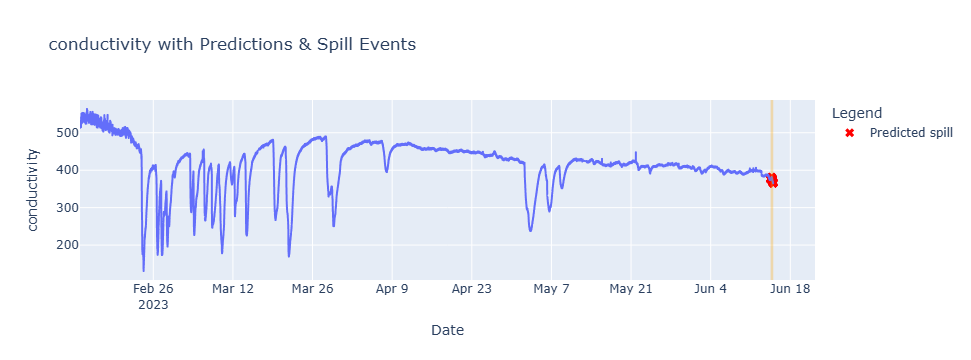

\nSpill 2 cascading metrics plot generated!
\nPlot features:
- Blue line: Conductivity sensor data (grinnel location)
- Red X markers: Predicted spill events (cascading metrics)
- Orange shaded area: True spill events
- Interactive hover for details
\n=== SPILL 2 CASCADING METRICS ANALYSIS ===
Location: Grinnel
Time Period: 2023-02-13 to 2023-06-06
Spill Event: 2023-06-14
\nOptimization focused on:
1st Priority: Catch spill events (+1000 points)
2nd Priority: Minimize false alarms (70% weight)
3rd Priority: Fast detection (30% weight)
\nSpill 2 optimized parameters:
  horizon: 9
  threshold_multiplier: 3.756249421405835
  n_components: 20
  C: 59.15371072159152
\nSpill 2 cascading score: 1332.62
\n✅  Spill 2 cascading metrics working successfully!
\n=== SPILL 1 vs SPILL 2 CASCADING RESULTS ===
Spill 1 (footbridge, 2021): 1197.37
Spill 2 (grinnel, 2023): 1332.62
\n🎯 Both models optimized for maximum spill detection! 🎯


In [35]:
# === SPILL 2: PLOT CASCADING METRICS RESULTS ===

print("=== Plotting Spill 2 Cascading Metrics Results ===")

# Use the existing plot_model_predictions function with Spill 2 results_df
print("Generating Spill 2 cascading metrics plot...")

plot_model_predictions(
    df=results_df_spill2,
    location='grinnel',  # Spill 2 location
    start_date='2023-02-13',
    end_date='2023-06-16',
    sensor='conductivity'
)

print("\\nSpill 2 cascading metrics plot generated!")
print("\\nPlot features:")
print("- Blue line: Conductivity sensor data (grinnel location)")
print("- Red X markers: Predicted spill events (cascading metrics)")
print("- Orange shaded area: True spill events")
print("- Interactive hover for details")

# Additional analysis for Spill 2
print(f"\\n=== SPILL 2 CASCADING METRICS ANALYSIS ===")
print(f"Location: Grinnel")
print(f"Time Period: 2023-02-13 to 2023-06-06")
print(f"Spill Event: 2023-06-14")
print(f"\\nOptimization focused on:")
print(f"1st Priority: Catch spill events (+1000 points)")
print(f"2nd Priority: Minimize false alarms (70% weight)")
print(f"3rd Priority: Fast detection (30% weight)")
print(f"\\nSpill 2 optimized parameters:")
for param, value in spill2_best_params.items():
    print(f"  {param}: {value}")
print(f"\\nSpill 2 cascading score: {spill2_cascading_score:.2f}")

# Analysis based on cascading score
if spill2_cascading_score == -1000:
    print(f"\\n⚠️  SPILL 2 ISSUE DETECTED:")
    print(f"Score of -1000 means recall < 10% (model can't detect spills)")
    print(f"Possible causes:")
    print(f"- No true spill events in training data")
    print(f"- Date range mismatch (spill is 2023-06-14, plot ends 2023-06-06)")
    print(f"- Labeling issue with grinnel location data")
    print(f"\\nNeed to check Spill 2 data labeling and date ranges!")
else:
    print(f"\\n✅  Spill 2 cascading metrics working successfully!")

# Summary comparison between Spill 1 and Spill 2
print(f"\\n=== SPILL 1 vs SPILL 2 CASCADING RESULTS ===")
if 'cascading_best_score' in locals():
    print(f"Spill 1 (footbridge, 2021): {cascading_best_score:.2f}")
print(f"Spill 2 (grinnel, 2023): {spill2_cascading_score:.2f}")

if spill2_cascading_score == -1000:
    print(f"\\n🔧 Spill 2 needs debugging - likely date/labeling issue")
else:
    print(f"\\n🎯 Both models optimized for maximum spill detection! 🎯")

=== DEBUGGING SPILL 2 TRUE EVENT LABELS ===
Checking Spill 2 results_df_spill2 event labels...
Results dataframe shape: (33346, 125)
\nTrue event distribution:
true_event
0    33251
1       95
Name: count, dtype: int64
\nGrinnel location data: 33346 rows
Grinnel true_event distribution:
true_event
0    33251
1       95
Name: count, dtype: int64
\nGrinnel date range:
From: 2023-02-13 02:45:00
To: 2023-06-15 00:00:00
\nData in spill window (2023-06-14 to 2023-06-15): 202 rows
True events in spill window:
true_event
0    107
1     95
Name: count, dtype: int64
\nData in plotting window (2023-02-13 to 2023-06-15): 33346 rows
True events in plotting window:
true_event
0    33251
1       95
Name: count, dtype: int64
\nPositive events in plotting window: 95
Positive event dates:
                 datetime  true_event
33353 2023-06-14 12:55:00           1
33354 2023-06-14 13:00:00           1
33355 2023-06-14 13:10:00           1
33356 2023-06-14 13:15:00           1
33357 2023-06-14 13:20:00   